# In this tutorial, we will run SED fitting to selected sample galaxies using Dense basis

In [1]:
import dense_basis as db

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

## Read the catalogs

In [3]:
# Directory of the catalog: where the catalog is located
cat_dir = '/Users/abdurrouf/Research/students_projects/ITB/JWST_projects/catalogs/ngdeep/'
cat_eazy = fits.open('cosweb-grizli-v6.0-fix.eazypy.zout.fits')

# get the catalog data
cat_eazy_data = cat_eazy[1].data

# Right ascension and declination
ra = cat_eazy_data['ra']
dec = cat_eazy_data['dec']

# redshifts: spectroscopic and photometric redshifts
z_spec = cat_eazy_data['z_spec']
z_phot = cat_eazy_data['z_phot']

# rest-frame magnitudes in U, V, and J bands
restU = cat_eazy_data['restU']
restV = cat_eazy_data['restV']
restJ = cat_eazy_data['restJ']

# stellar mass (SM) and star formation rate (SFR)
SM = cat_eazy_data['mass']
SFR = cat_eazy_data['sfr']

# number of objects (i.e., galaxies)
ngals = len(ra)
print ('Number of galaxies in the catalog: %d' % ngals)

cat_eazy.close()

Number of galaxies in the catalog: 29358


In [4]:
cat_photo = fits.open('cosweb-grizli-v6.0-fix_phot_apcorr.fits')
# get the catalog data
cat_photo_data = cat_photo[1].data
cat_photo.close()

# check the list of filters and their names from the header information printed above
filter_names = ['f105w', 'f110w','f115w', 'f125w', 'f140w', 'f150w', 'f160w', 'f277w',
                'f350lpu', 'f435w', 'f444w', 'f475w', 'f606w', 'f814w', 'f850lp']
nfilters = len(filter_names)
print ('Number of filters: %d' % nfilters)

# get central wavelength of the filters
filter_cwave = np.zeros(nfilters)
for bb in range(nfilters):
    filter_cwave[bb] = cat_photo[1].header[filter_names[bb]+'_PLAM']
    
# get the fluxes in units of micro Jansky (uJy)
# The measurements were done with circular aperture with 0.7 arcsecond diameter
# Now the fluxes have been corrected for the flux loss due to the small aperture 
flux = {}
flux_err = {}
for bb in range(nfilters):
    flux[filter_names[bb]] = np.zeros(ngals)
    flux_err[filter_names[bb]] = np.zeros(ngals)
    
for ii in range(ngals):
    for bb in range(nfilters):
        #flux[filter_names[bb]][ii] = cat_photo_data[filter_names[bb]+'_flux_aper_2'][ii]
        #flux_err[filter_names[bb]][ii] = cat_photo_data[filter_names[bb]+'_fluxerr_aper_2'][ii]
        flux[filter_names[bb]][ii] = cat_photo_data[filter_names[bb]+'_tot_2'][ii]
        flux_err[filter_names[bb]][ii] = cat_photo_data[filter_names[bb]+'_etot_2'][ii]

Number of filters: 15


## Try a simple selection criteria

In [5]:
ids_sample_galaxies = [12723,  4155,  6890,  3814,  5645,   258, 13815, 25358, 22648,
       16641,   520, 20788, 24897,  5396,  3012,  5343, 22890, 20745,
       24388, 28106,  1076, 13551,  7363, 12220,   648, 19785, 22068,
       14834, 13333, 28616,  6606,  2471,  8857, 12528,  6953, 28308,
        1880,  8834, 19132, 10195, 19631, 22358,  1639, 27834, 18770,
       12404,  8952, 22751, 16069,  4578, 10024, 24749,  8927, 13423,
       16275,  1819,  4264, 14475, 14494, 28103, 12485, 16151,  7784,
       10169, 23310, 25386, 15343, 12877, 13067,  5201, 16039, 21732,
         220, 14196, 12594, 12644, 20980, 22650, 11169, 18558,  1954,
        6048]
ngals_sample = len(ids_sample_galaxies)
print ("Number of selected galaxies: %d" % ngals_sample)

Number of selected galaxies: 82


## Get the spectral energy distribution (SED) of the selected galaxies

In [6]:
# First, we need to sort the filters from shortest to longest wavelength
sort_idx = np.argsort(filter_cwave)

sorted_filter_names = [] 
sorted_filter_cwave = []
for bb in range(nfilters):
    sorted_filter_names.append(filter_names[sort_idx[bb]])
    sorted_filter_cwave.append(filter_cwave[sort_idx[bb]])
    
sorted_filter_cwave = np.asarray(sorted_filter_cwave)

# get the SEDs (which is fluxes across the filters/wavelength)
gal_SED_flux = np.zeros((ngals_sample,nfilters))
gal_SED_flux_err = np.zeros((ngals_sample,nfilters))
for ii in range(ngals_sample):
    idx_gal = ids_sample_galaxies[ii]
    for bb in range(nfilters):
        gal_SED_flux[ii][bb] = flux[sorted_filter_names[bb]][int(idx_gal)]
        gal_SED_flux_err[ii][bb] = flux_err[sorted_filter_names[bb]][int(idx_gal)]
        
print (sorted_filter_names)

['f435w', 'f475w', 'f350lpu', 'f606w', 'f814w', 'f850lp', 'f105w', 'f110w', 'f115w', 'f125w', 'f140w', 'f150w', 'f160w', 'f277w', 'f444w']


## Run SED fitting with Dense basis

### First, Setting the list of filter names that are recognized by piXedfit

In [7]:
## set the list of filters. The filter names should be those recognized in piXedfit system
# To see the list of filters recognized in piXedfit
#dir_file = '/Users/novansaputra/piXedfit/data/filters/'
from piXedfit.utils.filtering import list_filters

list_filters()

2mass_h
2mass_j
2mass_k
akari_n160
akari_n60
akari_wide_l
akari_wide_s
alma_b3_2945
alma_b5_1288
alma_b6_1140
alma_b6_1199
alma_band4
alma_band6
cfht_mega_g
cfht_mega_i
cfht_mega_r
cfht_mega_u
cfht_mega_z
cfht_wircam_h
cfht_wircam_j
cfht_wircam_ks
euclid_h
euclid_j
euclid_vis
euclid_y
galex_fuv
galex_nuv
herschel_pacs_100
herschel_pacs_160
herschel_pacs_70
herschel_spire_250
herschel_spire_350
herschel_spire_500
hsc_g
hsc_i
hsc_nb1010
hsc_nb387
hsc_nb816
hsc_nb921
hsc_r
hsc_y
hsc_z
hst_acs_f435w
hst_acs_f475w
hst_acs_f555w
hst_acs_f606w
hst_acs_f625w
hst_acs_f775w
hst_acs_f814w
hst_acs_f850lp
hst_nicmos_f110w
hst_nicmos_f160w
hst_wfc3_ir_f105w
hst_wfc3_ir_f110w
hst_wfc3_ir_f125w
hst_wfc3_ir_f140w
hst_wfc3_ir_f160w
hst_wfc3_uvis2_f225w
hst_wfc3_uvis2_f275w
hst_wfc3_uvis2_f336w
hst_wfc3_uvis_f225w
hst_wfc3_uvis_f275w
hst_wfc3_uvis_f336w
hst_wfc3_uvis_f350lp
hst_wfc3_uvis_f390w
hst_wfpc2_f300w
hst_wfpc2_f336w
hst_wfpc2_f450w
hst_wfpc2_f555w
hst_wfpc2_f606w
hst_wfpc2_f702w
hst_wfpc2_f814w


['2mass_h',
 '2mass_j',
 '2mass_k',
 'akari_n160',
 'akari_n60',
 'akari_wide_l',
 'akari_wide_s',
 'alma_b3_2945',
 'alma_b5_1288',
 'alma_b6_1140',
 'alma_b6_1199',
 'alma_band4',
 'alma_band6',
 'cfht_mega_g',
 'cfht_mega_i',
 'cfht_mega_r',
 'cfht_mega_u',
 'cfht_mega_z',
 'cfht_wircam_h',
 'cfht_wircam_j',
 'cfht_wircam_ks',
 'euclid_h',
 'euclid_j',
 'euclid_vis',
 'euclid_y',
 'galex_fuv',
 'galex_nuv',
 'herschel_pacs_100',
 'herschel_pacs_160',
 'herschel_pacs_70',
 'herschel_spire_250',
 'herschel_spire_350',
 'herschel_spire_500',
 'hsc_g',
 'hsc_i',
 'hsc_nb1010',
 'hsc_nb387',
 'hsc_nb816',
 'hsc_nb921',
 'hsc_r',
 'hsc_y',
 'hsc_z',
 'hst_acs_f435w',
 'hst_acs_f475w',
 'hst_acs_f555w',
 'hst_acs_f606w',
 'hst_acs_f625w',
 'hst_acs_f775w',
 'hst_acs_f814w',
 'hst_acs_f850lp',
 'hst_nicmos_f110w',
 'hst_nicmos_f160w',
 'hst_wfc3_ir_f105w',
 'hst_wfc3_ir_f110w',
 'hst_wfc3_ir_f125w',
 'hst_wfc3_ir_f140w',
 'hst_wfc3_ir_f160w',
 'hst_wfc3_uvis2_f225w',
 'hst_wfc3_uvis2_f275w'

In [8]:
## set the list of filters for SED fitting
filters = ['hst_acs_f435w', 'hst_acs_f475w', 'hst_wfc3_uvis_f350lp', 
           'hst_acs_f606w', 'hst_acs_f814w', 'hst_acs_f850lp', 'hst_wfc3_ir_f105w', 'hst_nicmos_f110w', 
           'jwst_nircam_f115w', 'hst_wfc3_ir_f125w', 'hst_wfc3_ir_f140w', 'jwst_nircam_f150w', 'hst_wfc3_ir_f160w', 'jwst_nircam_f277w', 'jwst_nircam_f444w']

In [9]:
# Dense basis requires that we put filter transmission curves into text files
# We can get these filter curves from piXedfit and make text files to store them
# The following function does this

def make_filter_curves_txt(filters,filter_list,filt_dir):
    import os
    from piXedfit.utils.filtering import get_filter_curve
    
    if os.path.exists(filt_dir) == False:
        os.system('mkdir %s' % filt_dir)
        
    file_out1 = open(filt_dir+'/'+filter_list,'w')
    for bb in range(len(filters)):
        filter_name = filters[bb]+'.txt'
        if bb < len(filters)-1:
            file_out1.write('%s\n' % filter_name)
        else:
            file_out1.write('%s ' % filter_name)   ## important note: give a space after the last text

        wave, trans = get_filter_curve(filters[bb])
        file_out = open(filt_dir+'/'+filter_name,'w')
        for ii in range(len(wave)):
            file_out.write('%lf %lf\n' % (wave[ii],trans[ii]))
        file_out.close()
    file_out1.close()

In [10]:
filter_list = 'filter_list.txt'
filt_dir = 'filters'
make_filter_curves_txt(filters,filter_list,filt_dir)

### Second, generate atlas (dense basis) of model SEDs

In [13]:
fname = 'cosweb_atlas'
N_pregrid = 900000
path = 'pregrids/'
N_param = 5

In [14]:
atlas = db.load_atlas(fname, N_pregrid=N_pregrid, N_param=N_param, path=path)

sfh_50_list = []
sfh_16_list = []
sfh_84_list = []
common_time_list = []
mstar_list = []
sfr_list = []
Z_list = []
Av_list = []
rs_list = []
t17_list = []
t33_list = []
t50_list = []
t67_list = []
t83_list = []

for i in range(ngals_sample):
    k = ids_sample_galaxies[i]
    obs_flux = gal_SED_flux[i]
    obs_flux_err = abs(gal_SED_flux_err[i])
    sedfit = db.SedFit(obs_flux, obs_flux_err, atlas, fit_mask=[])
    sedfit.evaluate_likelihood()
    sedfit.evaluate_posterior_percentiles(percentile_values=[16.,50.,84.])
    sfh_50, sfh_16, sfh_84, common_time = sedfit.evaluate_posterior_SFH(sedfit.z[1])
    sfh_50_list.append(sfh_50)
    sfh_16_list.append(sfh_16)
    sfh_84_list.append(sfh_84)
    common_time_list.append(common_time)
    mstar_list.append(sedfit.mstar)
    sfr_list.append(sedfit.sfr)
    Z_list.append(sedfit.Z)
    Av_list.append(sedfit.Av)
    rs_list.append(sedfit.z)
    t17_list.append(sedfit.sfh_tuple[:,3])
    t33_list.append(sedfit.sfh_tuple[:,4])
    t50_list.append(sedfit.sfh_tuple[:,5])
    t67_list.append(sedfit.sfh_tuple[:,6])
    t83_list.append(sedfit.sfh_tuple[:,7])
    print(i/ngals_sample * 100)

0.0
1.2195121951219512
2.4390243902439024
3.6585365853658534
4.878048780487805
6.097560975609756
7.317073170731707
8.536585365853659
9.75609756097561
10.975609756097562
12.195121951219512
13.414634146341465
14.634146341463413
15.853658536585366
17.073170731707318
18.29268292682927
19.51219512195122
20.73170731707317
21.951219512195124
23.170731707317074
24.390243902439025
25.609756097560975
26.82926829268293
28.04878048780488
29.268292682926827
30.48780487804878
31.70731707317073
32.926829268292686
34.146341463414636
35.36585365853659
36.58536585365854
37.80487804878049
39.02439024390244
40.243902439024396
41.46341463414634
42.68292682926829
43.90243902439025
45.1219512195122
46.34146341463415
47.5609756097561
48.78048780487805
50.0
51.21951219512195
52.4390243902439
53.65853658536586
54.87804878048781
56.09756097560976
57.3170731707317
58.536585365853654
59.756097560975604
60.97560975609756
62.19512195121951
63.41463414634146
64.63414634146342
65.85365853658537
67.07317073170732
68.29

In [14]:
sedfit.sfh_tuple

array([[10.9785,  1.6065,  3.    ,  0.3445,  0.4855,  0.6365],
       [11.0665,  1.8365,  3.    ,  0.3695,  0.4985,  0.7165],
       [11.0815,  2.0175,  3.    ,  0.5355,  0.7035,  0.8305]])

In [12]:
import math

##==> Define priors
# Priors class, to see all the options look in the priors.py file in the dense_basis folder
priors = db.Priors()
priors.mass_min = 6.
priors.mass_max = 12.

# SFH priors
priors.Nparam = 5
priors.tx_alpha = np.ones((priors.Nparam+1,))*5.0
priors.tx_alpha[0] = 12.
# priors.tx_alpha[1] = 5.
# added this for v2
# priors.tx_alpha[0] = 22.

# SFR prior
priors.sfr_prior_type = 'sSFRlognormal'
priors.dynamic_decouple = True

# metallicity prior
priors.met_treatment = 'flat'
priors.Z_min = -2.0
priors.Z_max = 0.3

# dust prior
priors.dust_prior = 'exp'
# priors.Av_exp_scale = 1.0
priors.Av_min = 0
priors.Av_max = 4 

# Redshift prior. Change this for other set of galaxies
# This is the redshift range of the sample selection above

fname = 'cosweb_atlas'
N_pregrid = 900000
path = 'pregrids/'

priors.z_min = 1.5
priors.z_max = 7.5

db.generate_atlas(N_pregrid=N_pregrid, priors=priors, fname=fname, 
                      store=True, path=path, filter_list=filter_list, filt_dir=filt_dir)

generating atlas with: 
5  tx parameters,  sSFRlognormal  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


100%|██████████████████████████| 900000/900000 [42:22:23<00:00,  5.90it/s]


Path exists. Saved atlas at : pregrids/cosweb_atlas_900000_Nparam_5.dbatlas


In [16]:
sfh_50_list = np.array(sfh_50_list)
sfh_16_list = np.array(sfh_16_list)
sfh_84_list = np.array(sfh_84_list)
common_time_list = np.array(common_time_list)
mstar_list = np.array(mstar_list)
sfr_list = np.array(sfr_list)
Z_list = np.array(Z_list)
Av_list = np.array(Av_list)
rs_list = np.array(rs_list)

field = 'cosweb'

with open('new_{}_sfh_50.txt'.format(field), 'w') as file:
    for i in range(len(sfh_50_list)):
        line = ''
        for j in range(len(sfh_50_list[i])):
            line += str(sfh_50_list[i][j])
            line += '\t'
        line += '\n'
        file.write(line)
        
with open('new_{}_sfh_16.txt'.format(field), 'w') as file:
    for i in range(len(sfh_16_list)):
        line = ''
        for j in range(len(sfh_16_list[i])):
            line += str(sfh_16_list[i][j])
            line += '\t'
        line += '\n'
        file.write(line)
        
with open('new_{}_sfh_84.txt'.format(field), 'w') as file:
    for i in range(len(sfh_84_list)):
        line = ''
        for j in range(len(sfh_84_list[i])):
            line += str(sfh_84_list[i][j])
            line += '\t'
        line += '\n'
        file.write(line)
        
with open('new_{}_common_time.txt'.format(field), 'w') as file:
    for i in range(len(common_time_list)):
        line = ''
        for j in range(len(common_time_list[i])):
            line += str(common_time_list[i][j])
            line += '\t'
        line += '\n'
        file.write(line)
        
with open('new_{}_fitting_densebasis.txt'.format(field), 'w') as file:
    line = f'#no\tindex\tlogM\tlogM_low\tlogM_hi\tSFR\tSFR_low\tSFR_hi\tZ\tZ_low\tZ_hi\tAv\tAv_low\tAv_hi\tredshift\tredshift_low\tredshift_hi\n'
    file.write(line)
    for i in range(ngals_sample):
        line = f'{i+1}\t{ids_sample_galaxies[i]}\t{mstar_list[i][1]}\t{mstar_list[i][0]}\t{mstar_list[i][2]}\t{sfr_list[i][1]}\t{sfr_list[i][0]}\t{sfr_list[i][2]}\t{Z_list[i][1]}\t{Z_list[i][0]}\t{Z_list[i][2]}\t{Av_list[i][1]}\t{Av_list[i][0]}\t{Av_list[i][2]}\t{rs_list[i][1]}\t{rs_list[i][0]}\t{rs_list[i][2]}\n'
        file.write(line)

Redshift: 5.75 < z < 6.0
Redshift: 6.0 < z < 6.25
generating atlas with: 
3  tx parameters,  sSFRlognormal  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


100%|█████████████████████████████████████| 10000/10000 [14:56<00:00, 11.15it/s]


Path exists. Saved atlas at : pregrids/atlas_10000_Nparam_3.dbatlas
Galaxy ID: CEERS-10276


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Redshift: 6.25 < z < 6.5
Redshift: 6.5 < z < 6.75
generating atlas with: 
3  tx parameters,  sSFRlognormal  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


100%|█████████████████████████████████████| 10000/10000 [14:59<00:00, 11.11it/s]


Path exists. Saved atlas at : pregrids/atlas_10000_Nparam_3.dbatlas
Galaxy ID: CEERS-38626


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

couldnt set axis limits
Redshift: 6.75 < z < 7.0
generating atlas with: 
3  tx parameters,  sSFRlognormal  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


100%|█████████████████████████████████████| 10000/10000 [15:02<00:00, 11.08it/s]


Path exists. Saved atlas at : pregrids/atlas_10000_Nparam_3.dbatlas
Galaxy ID: CEERS-397


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Galaxy ID: CEERS-20214


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<Figure size 640x480 with 0 Axes>

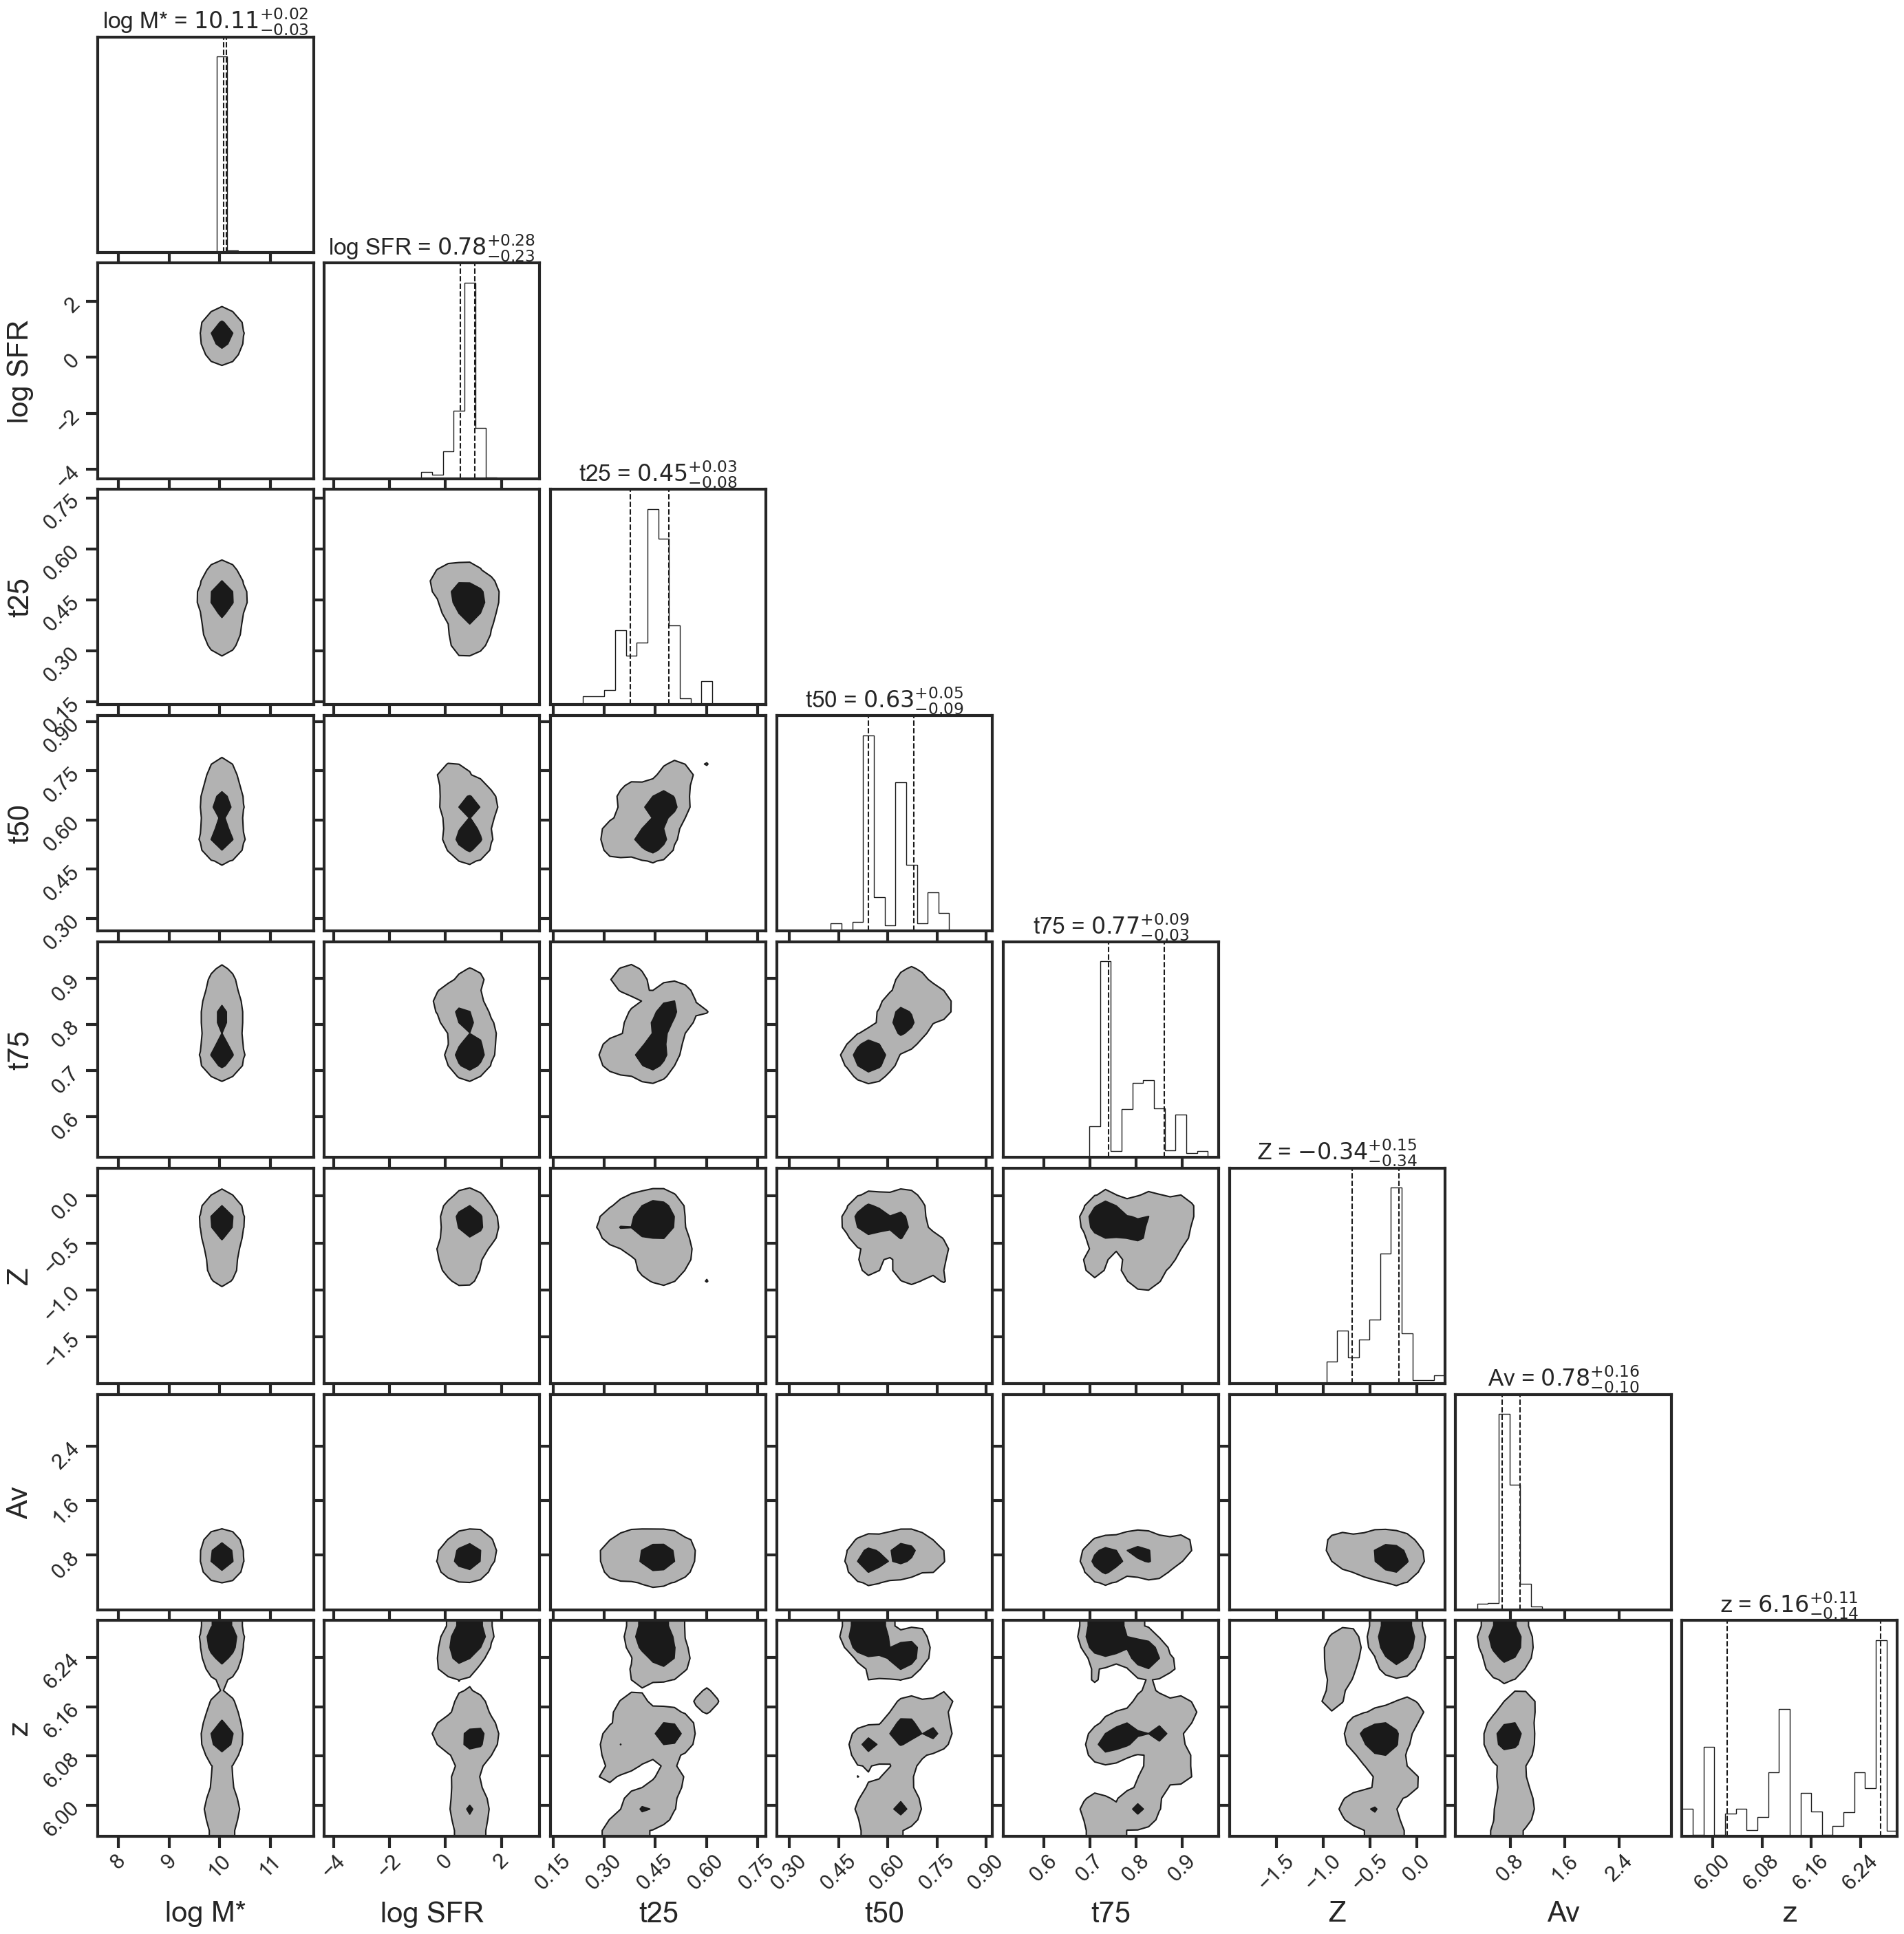

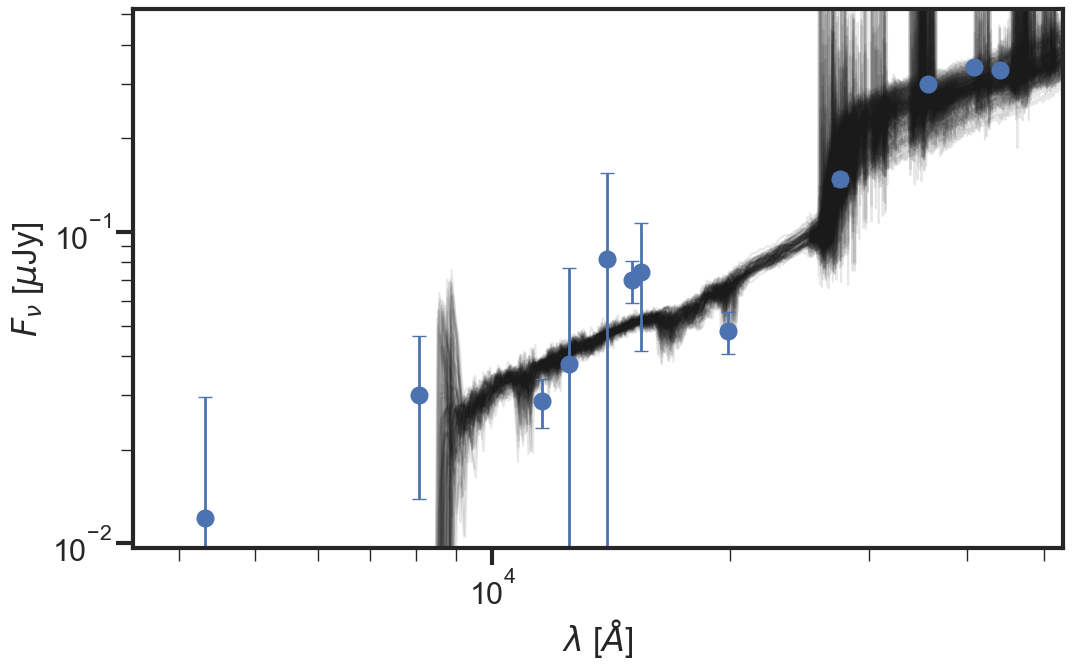

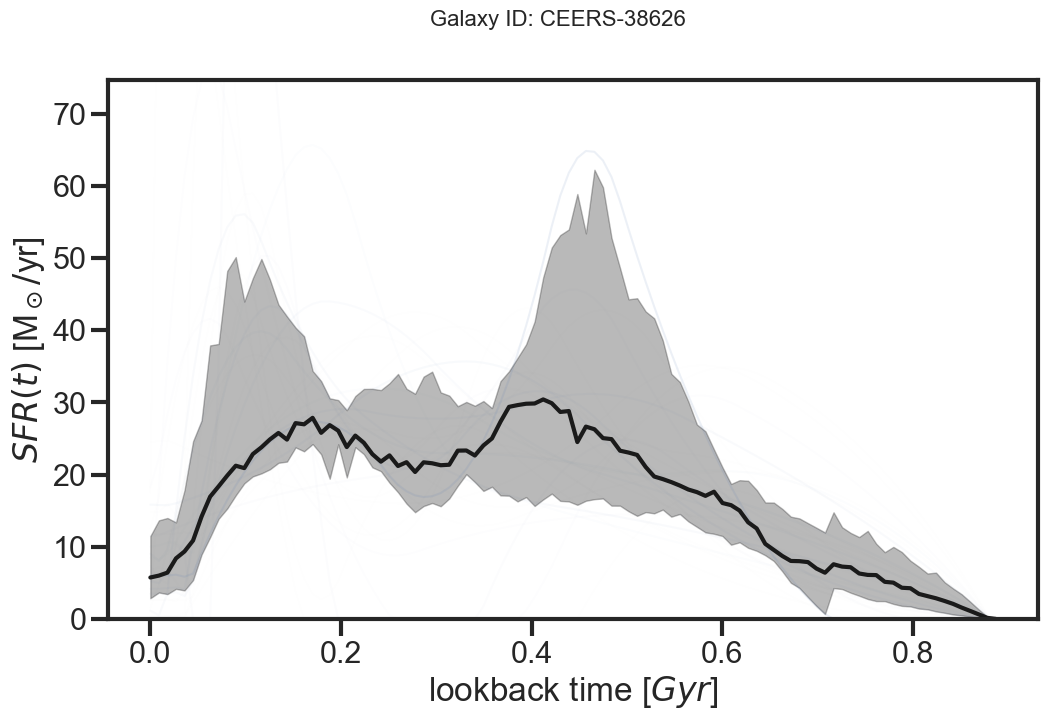

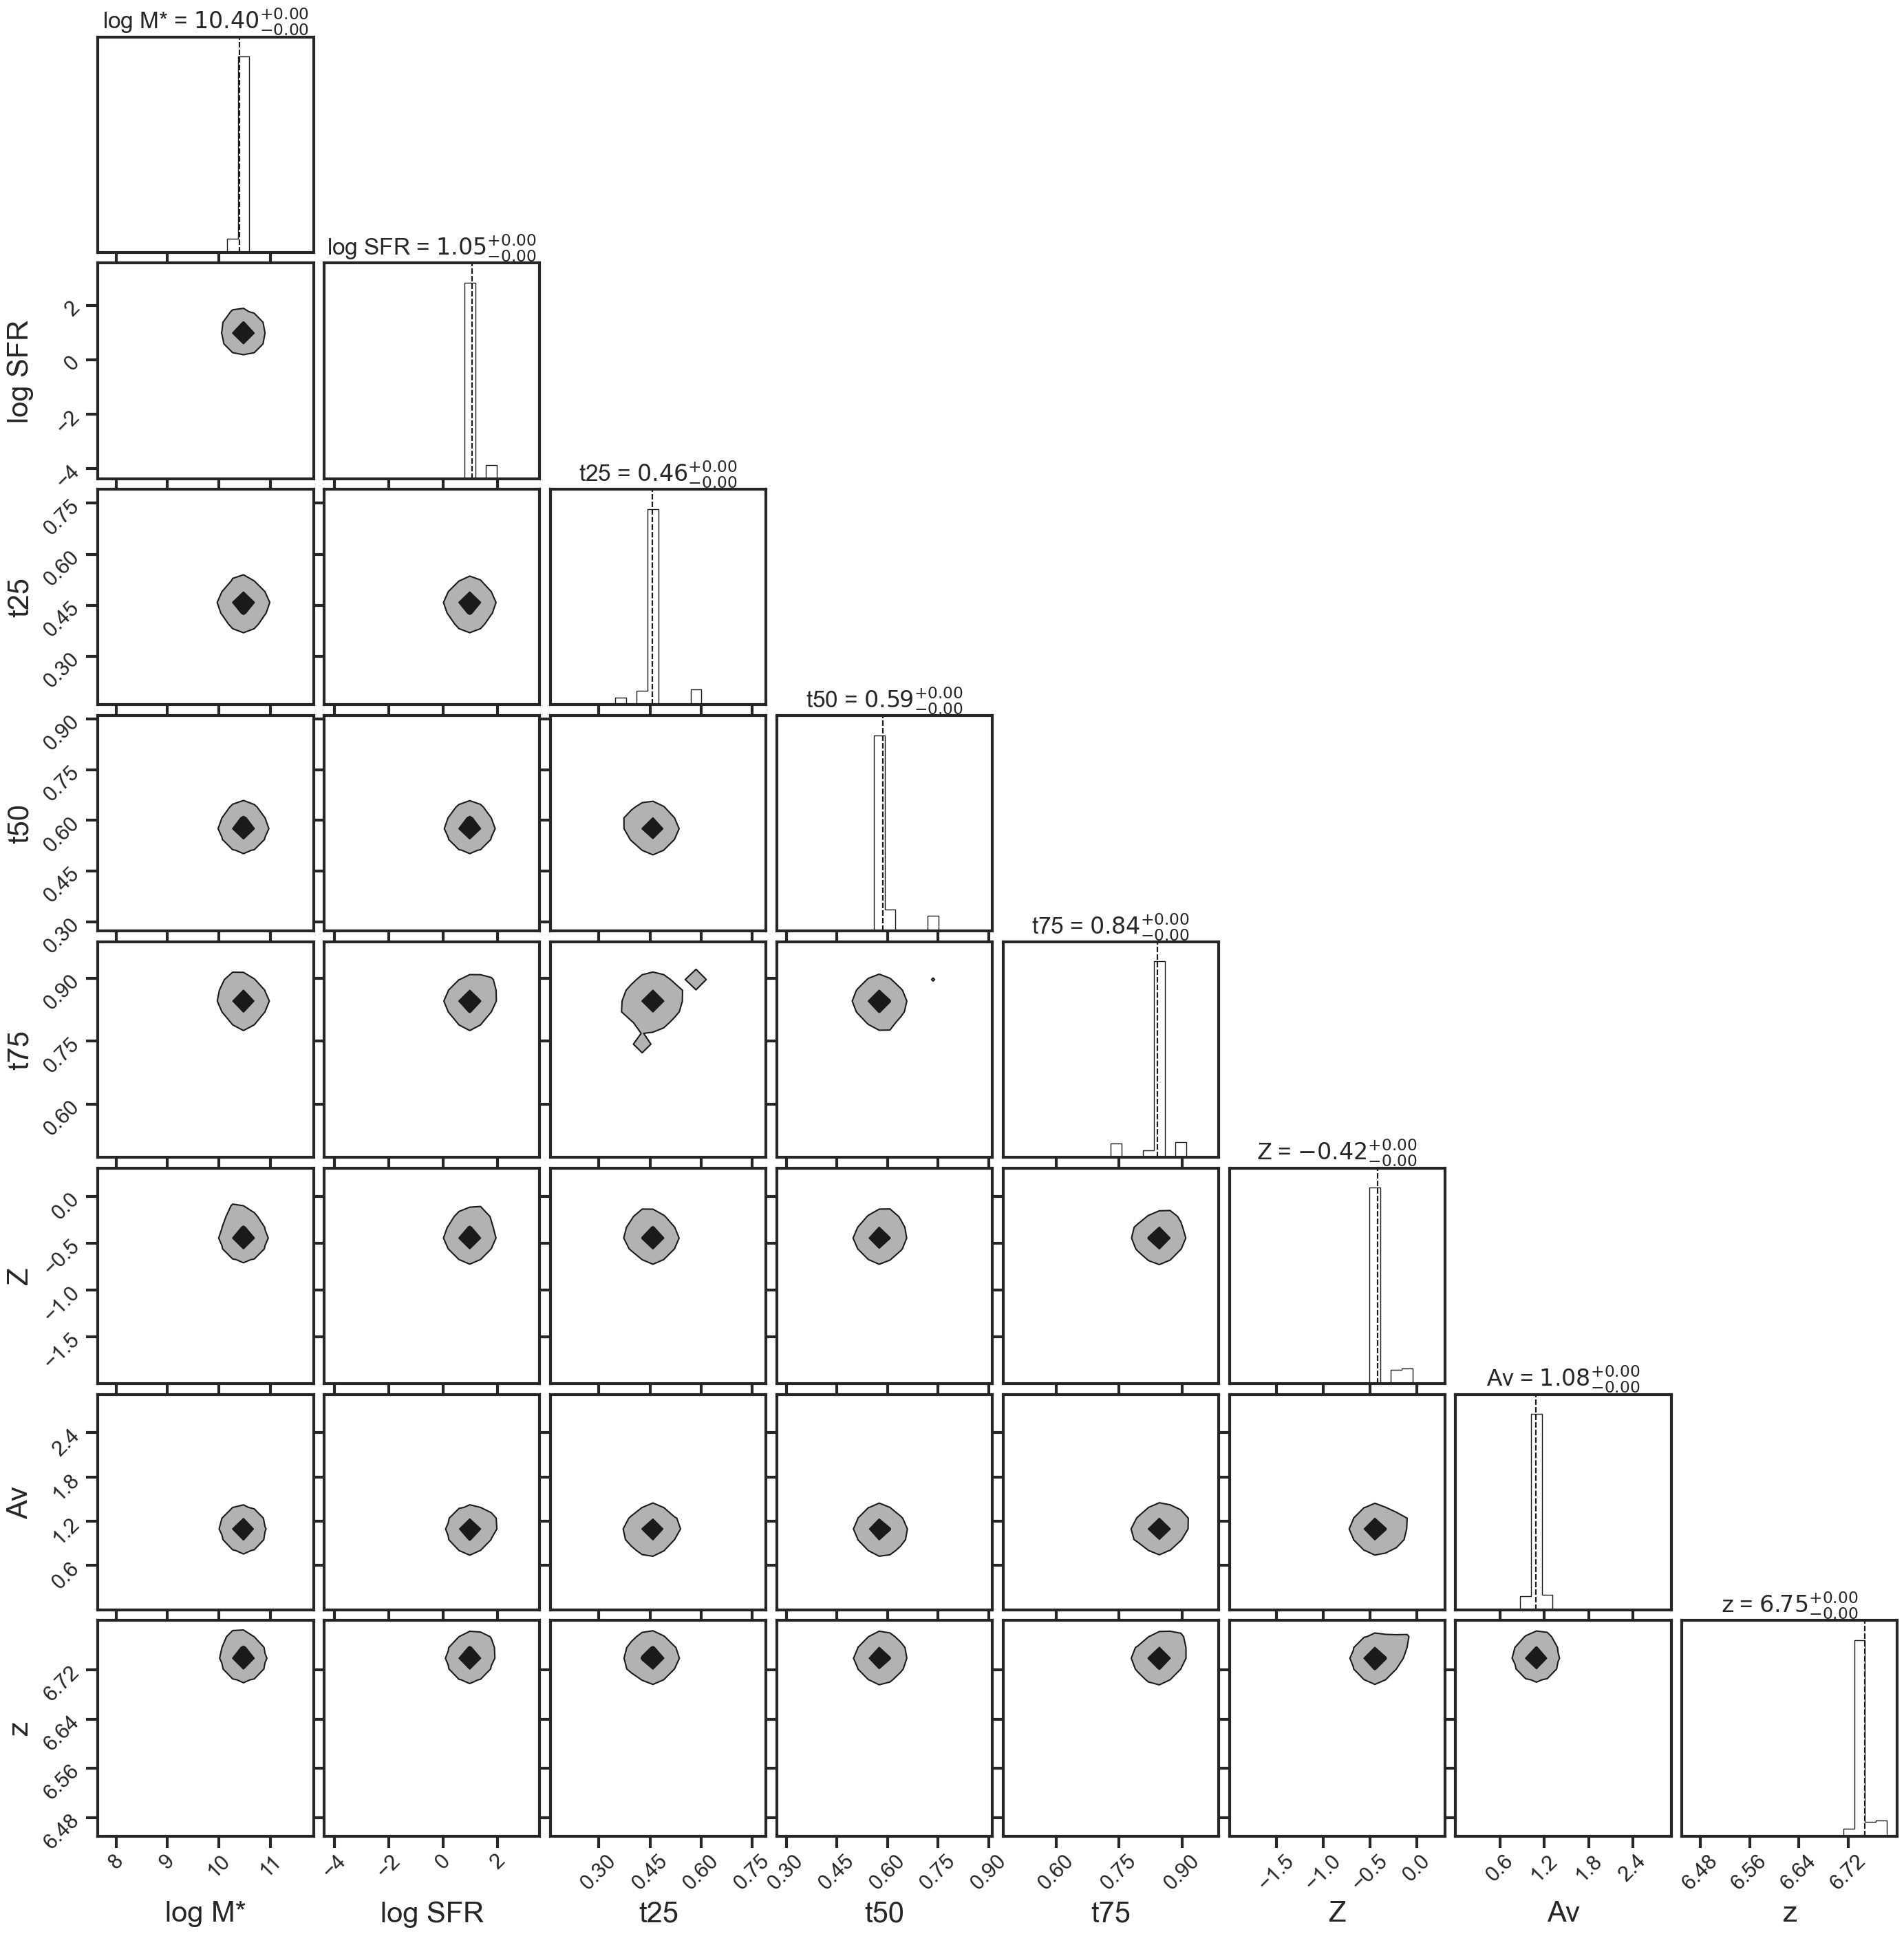

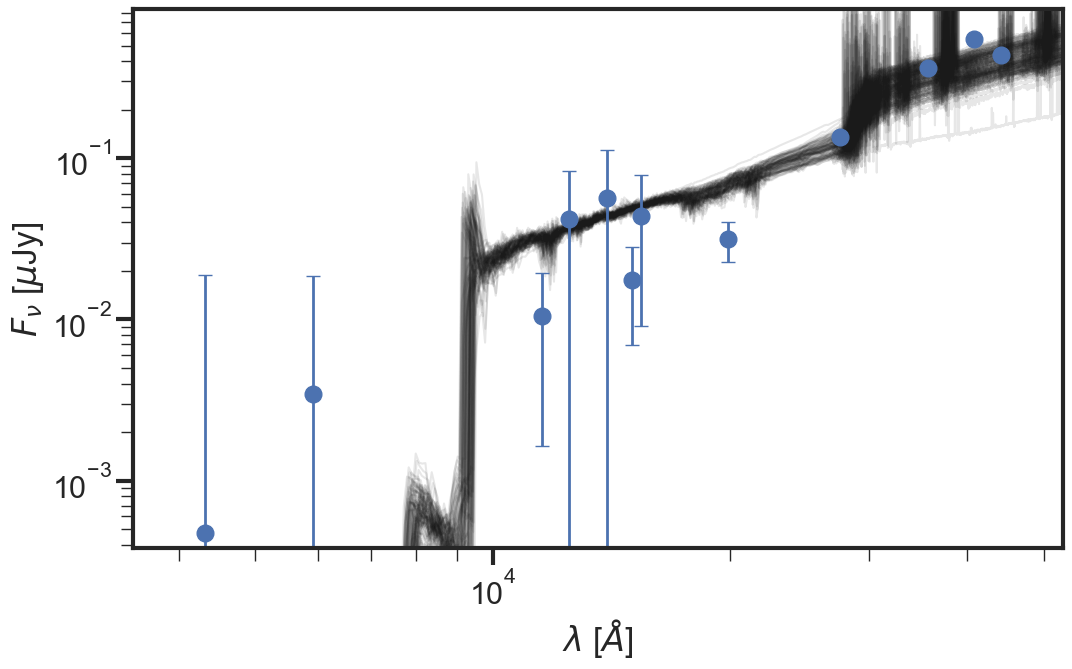

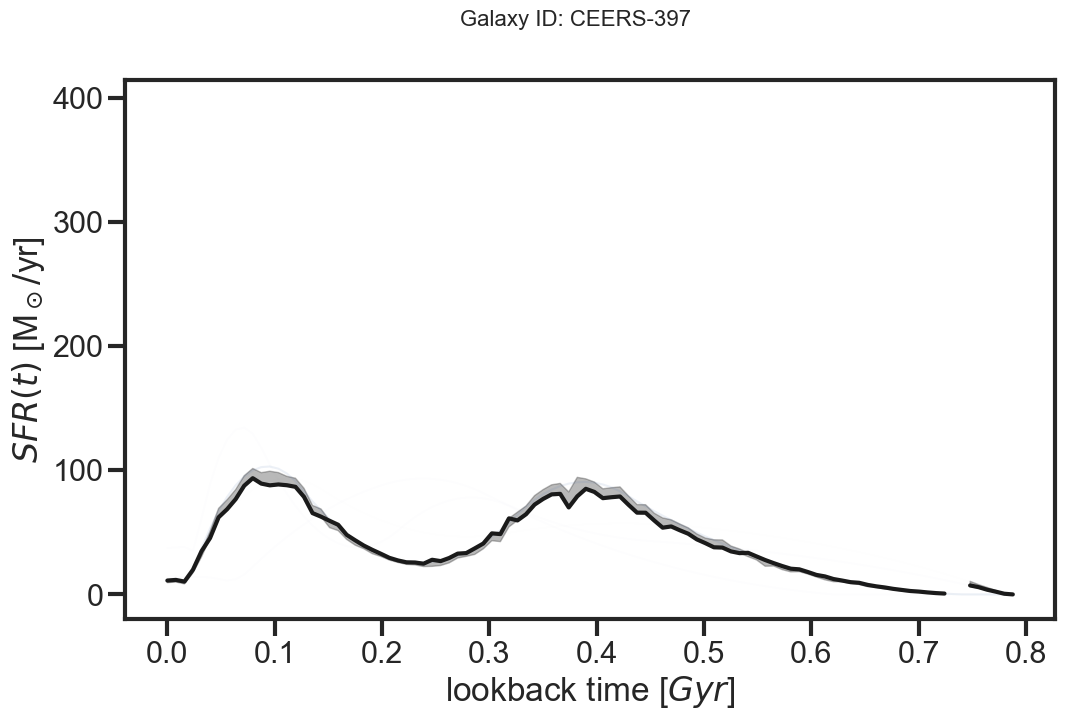

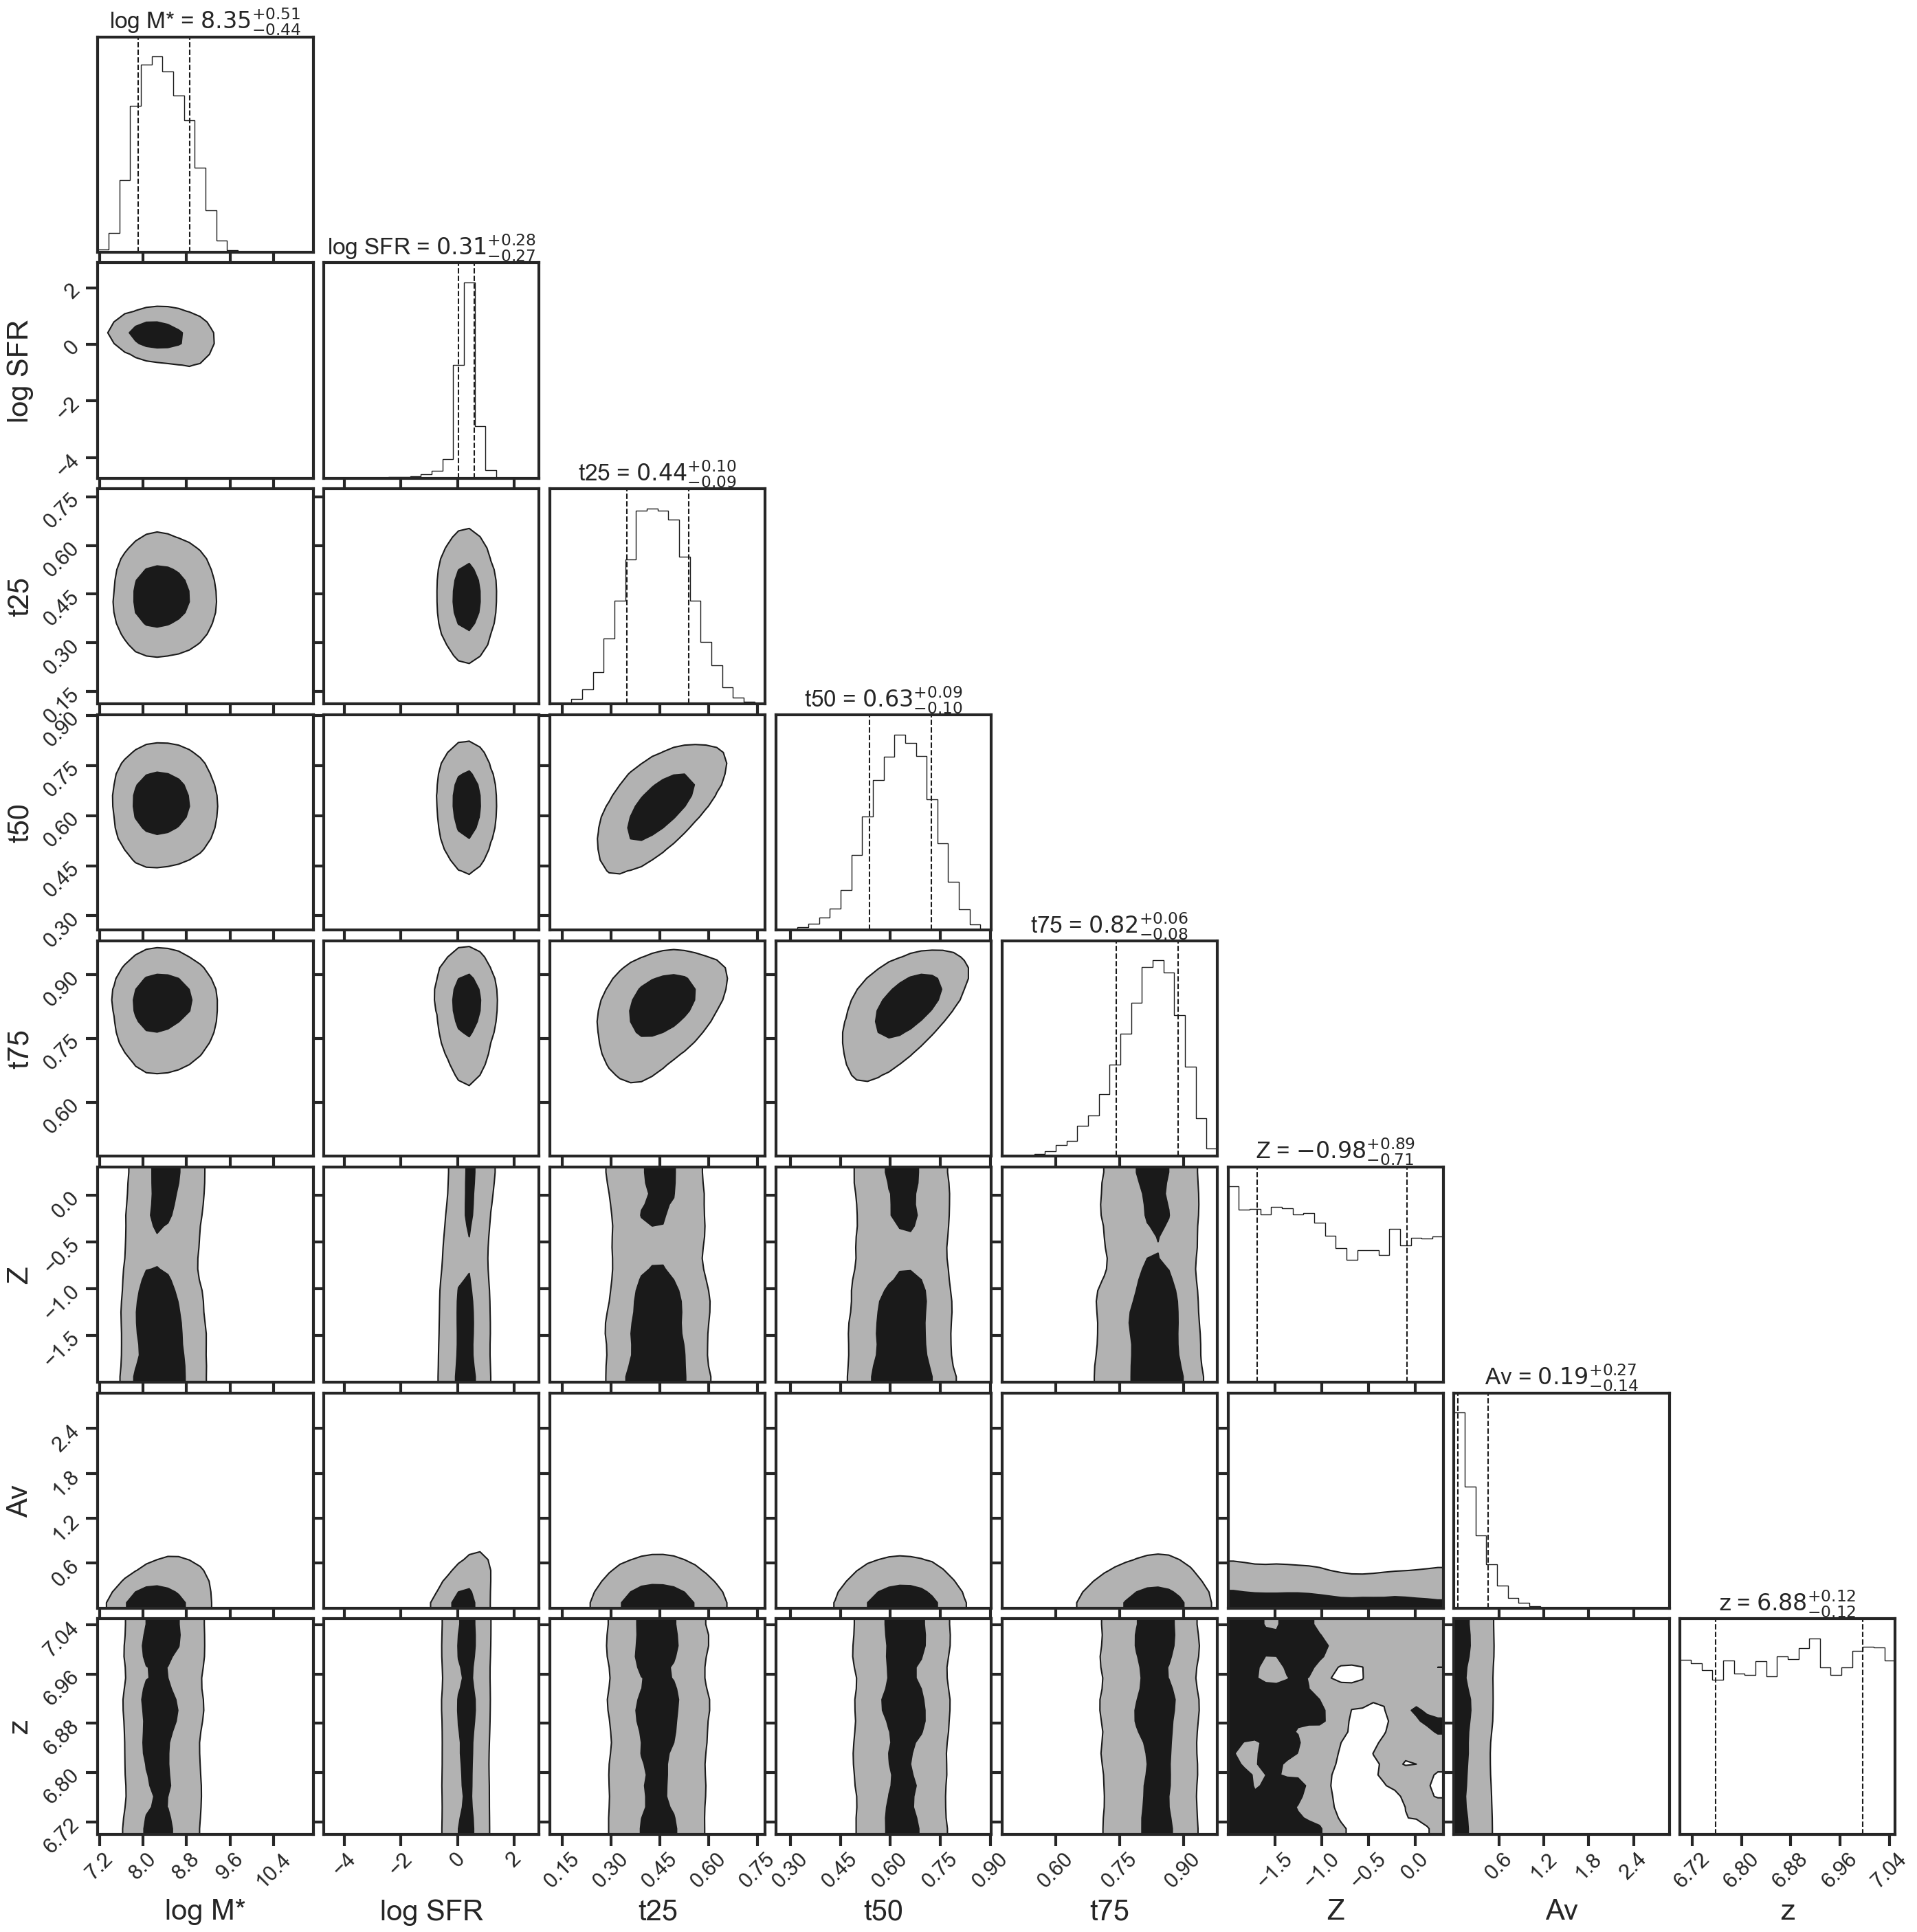

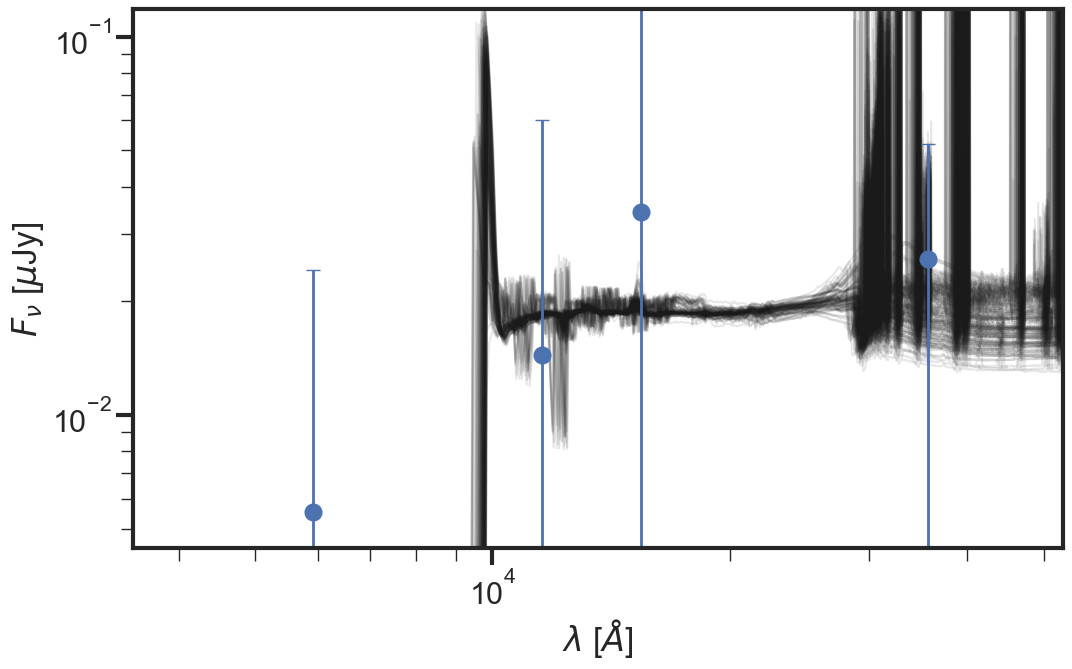

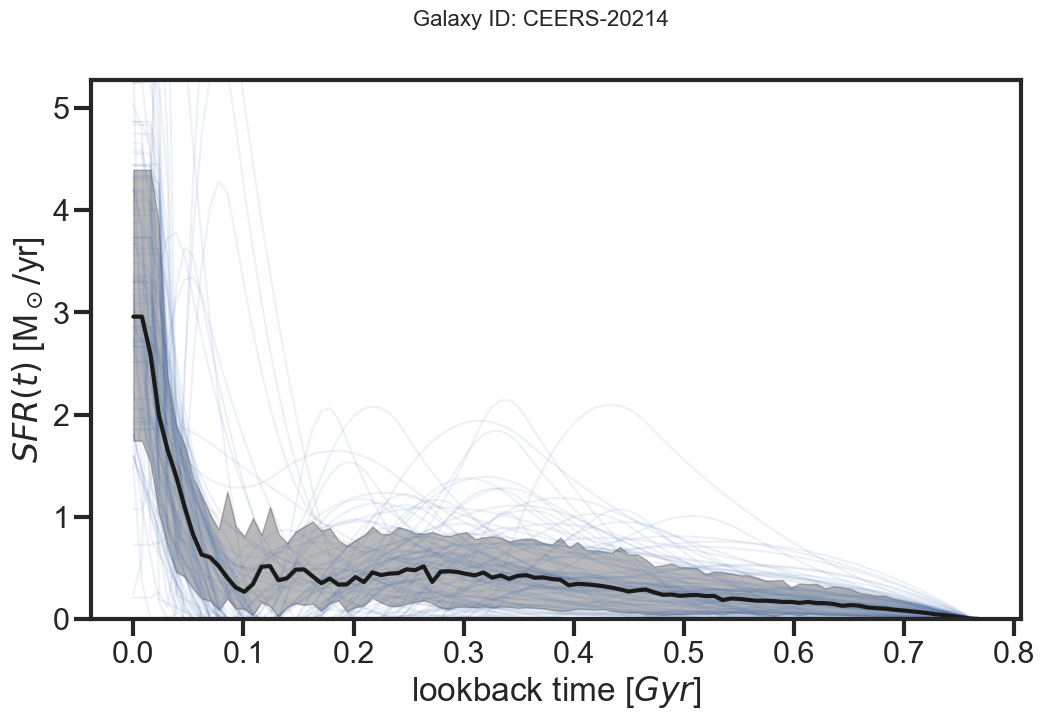

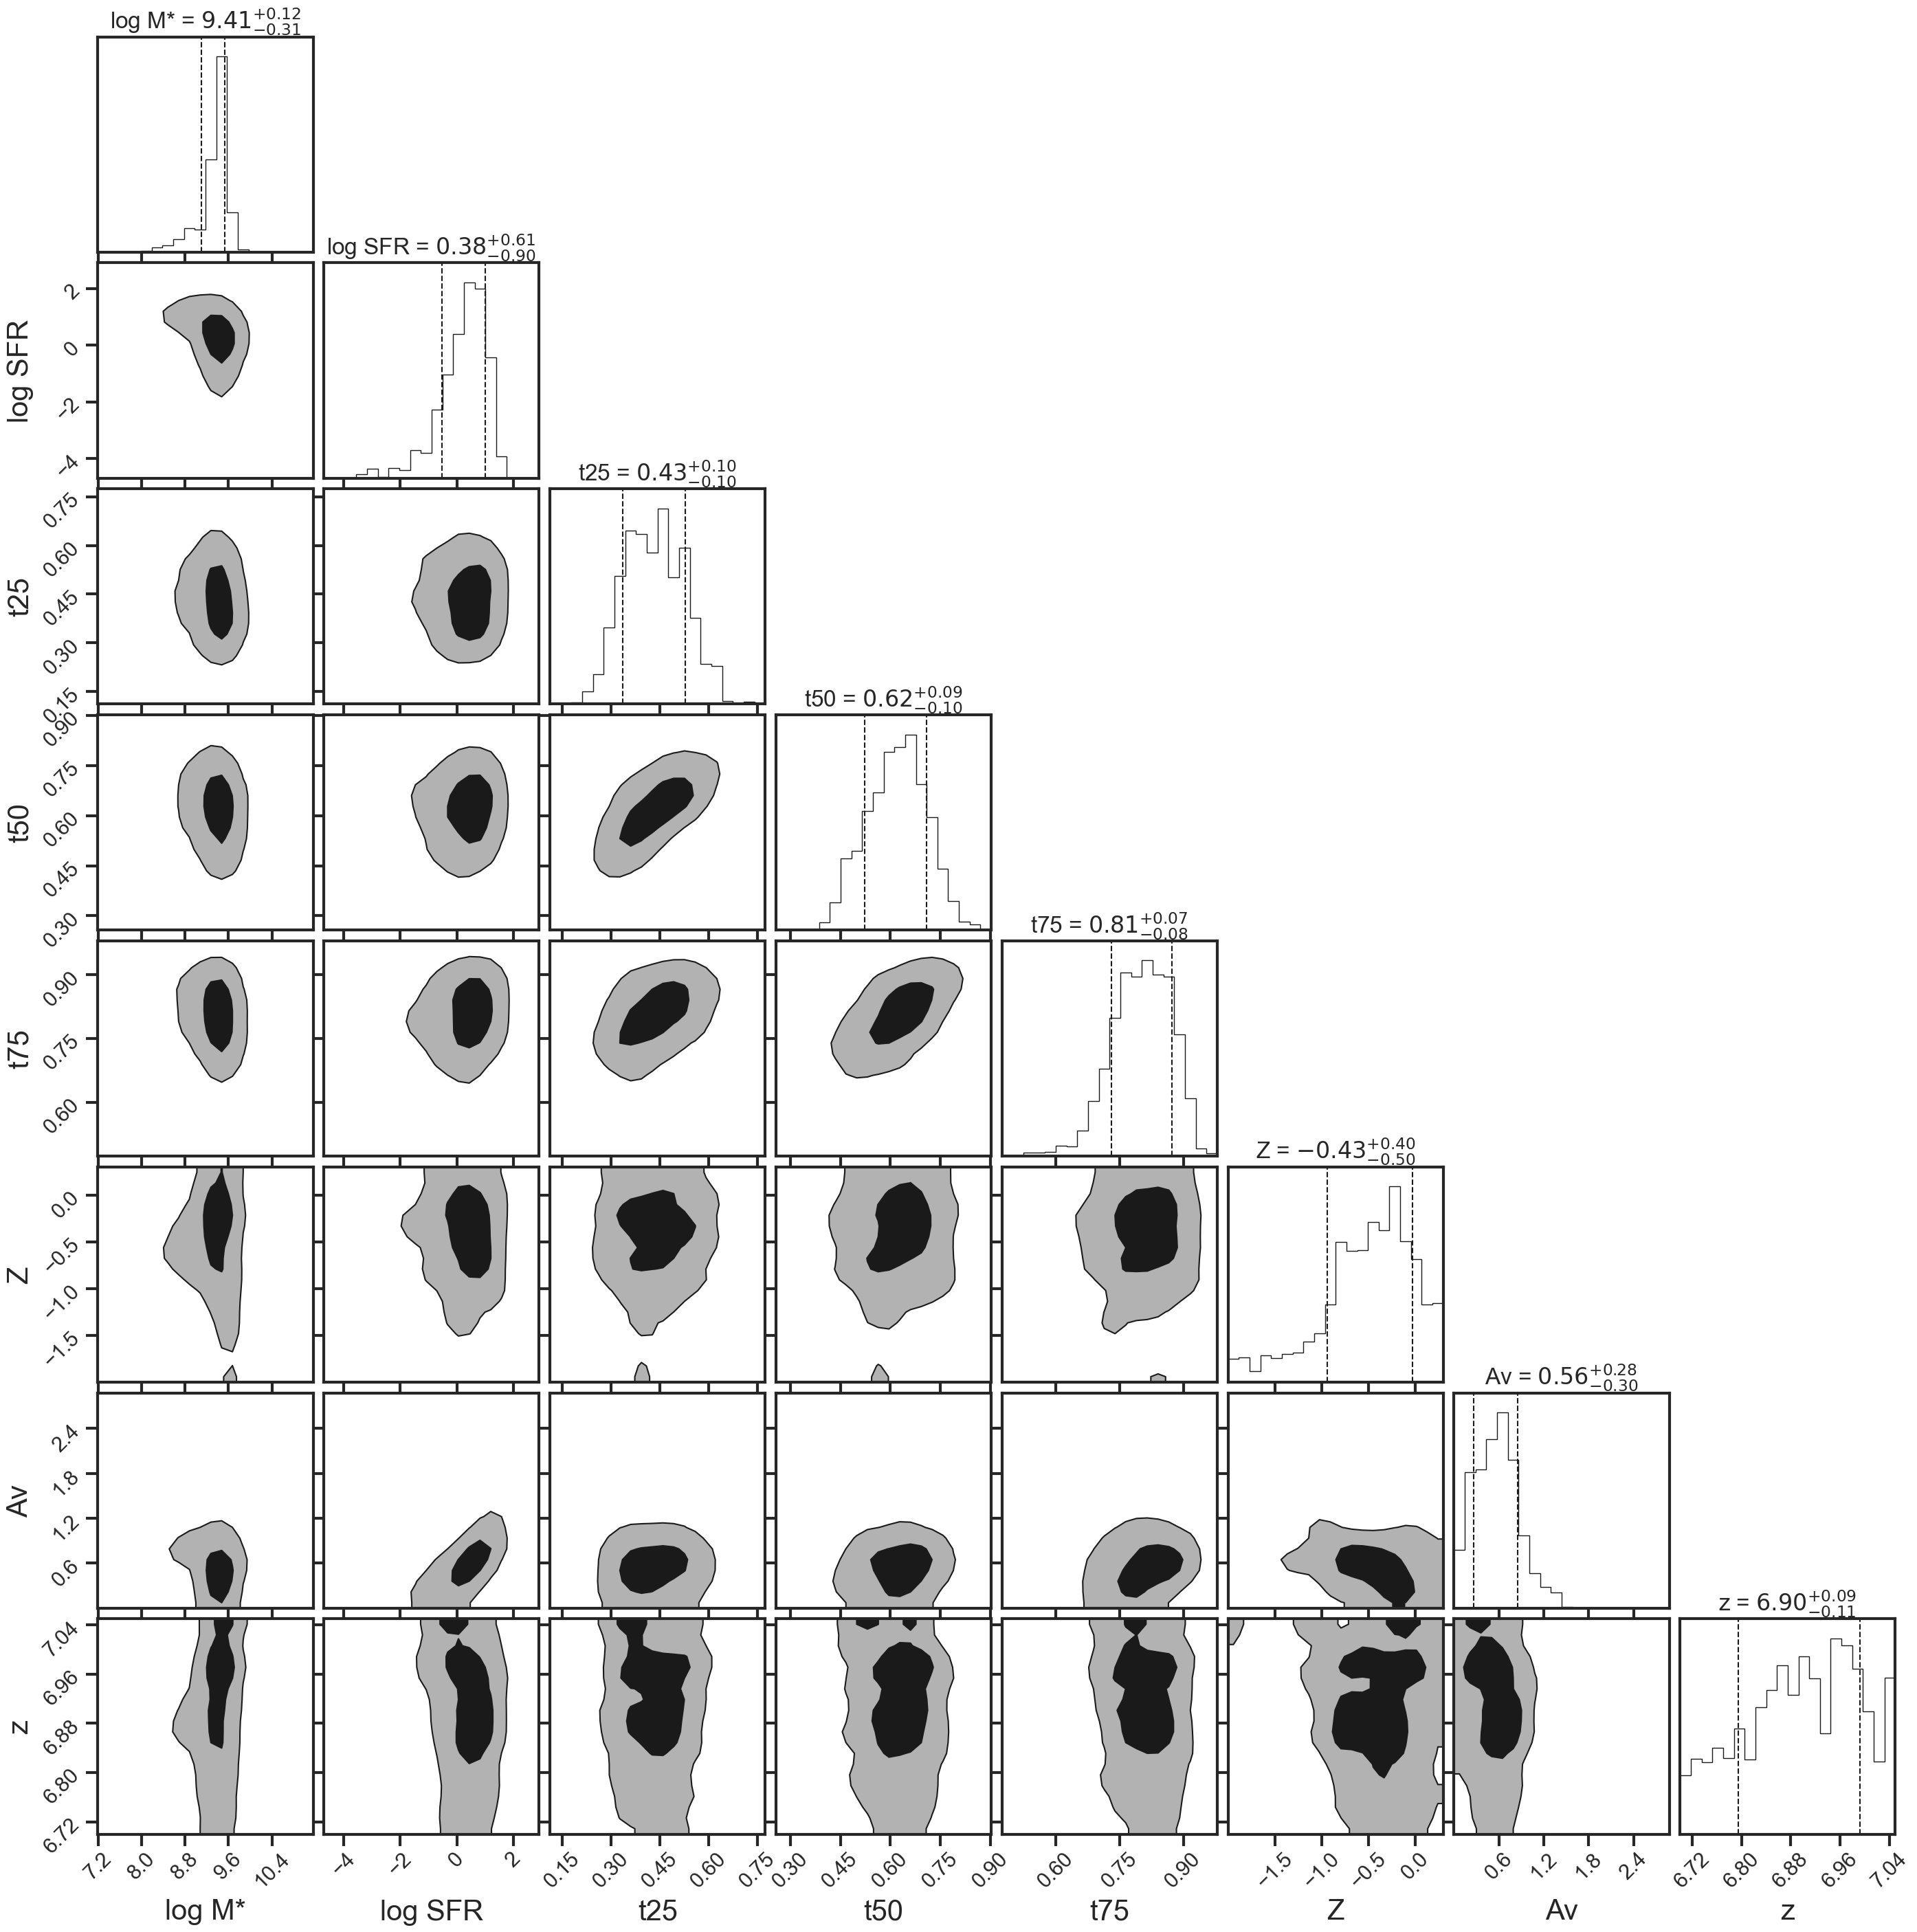

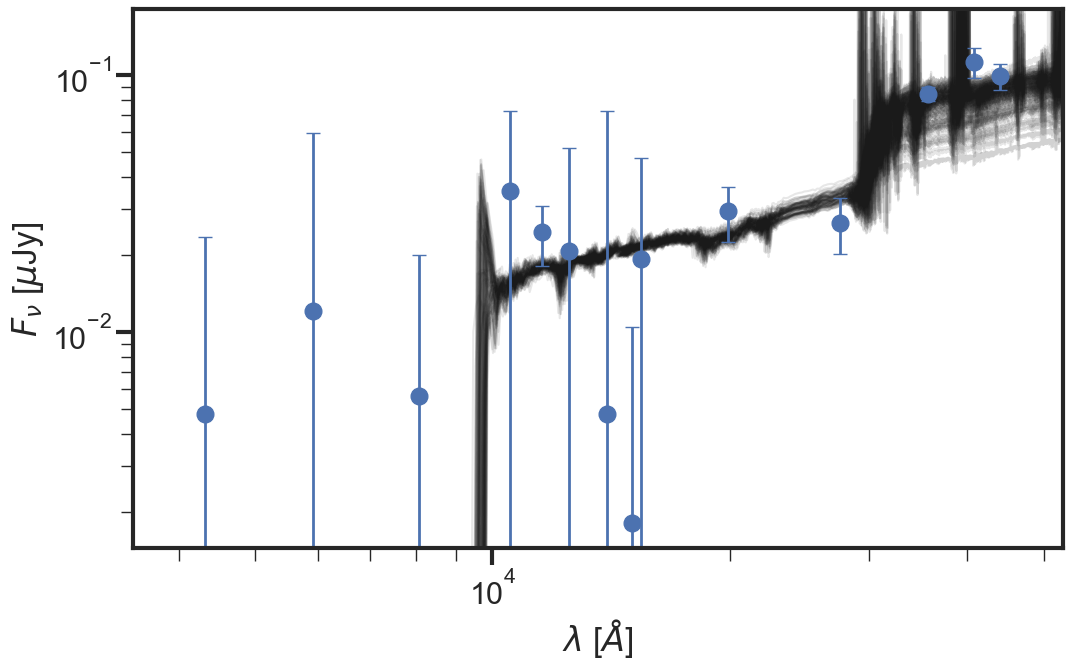

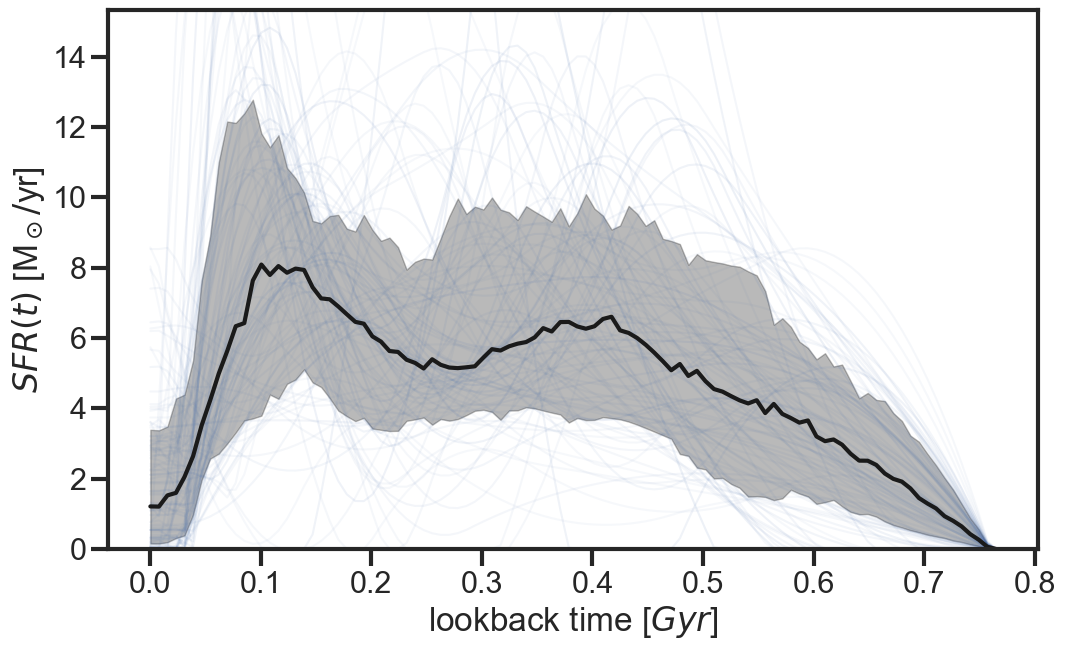

In [20]:
import math

##==> Define priors
# Priors class, to see all the options look in the priors.py file in the dense_basis folder
priors = db.Priors()
priors.mass_min = 6.
priors.mass_max = 12.

# SFH priors
priors.Nparam = 3
priors.tx_alpha = np.ones((priors.Nparam+1,))*5.0
priors.tx_alpha[0] = 12.
# priors.tx_alpha[1] = 5.
# added this for v2
# priors.tx_alpha[0] = 22.

# SFR prior
priors.sfr_prior_type = 'sSFRlognormal'
priors.dynamic_decouple = True

# metallicity prior
priors.met_treatment = 'flat'
priors.Z_min = -2.0
priors.Z_max = 0.3

# dust prior
priors.dust_prior = 'exp'
# priors.Av_exp_scale = 1.0
priors.Av_min = 0
priors.Av_max = 4 

# Redshift prior. Change this for other set of galaxies
# This is the redshift range of the sample selection above
z_bin = 0.25

fname = 'atlas'
N_pregrid = 10000
path = 'pregrids/'

fit_result_ceers_z4 = {}

for i in range(0,math.ceil(1.25/z_bin)):
    z_min = 5.75 + (i) * z_bin
    z_max = 5.75 + (i + 1) * z_bin
    print("Redshift: "+str(z_min)+" < z < "+str(z_max))
    priors.z_min = z_min - 0.05
    priors.z_max = z_max + 0.05
    
    gal_idx = np.where((z_phot[ids_sample_galaxies] > z_min) & (z_phot[ids_sample_galaxies] < z_max))
    
    if len(gal_idx[0]) > 0:
    
        db.generate_atlas(N_pregrid=N_pregrid, priors=priors, fname=fname, 
                      store=True, path=path, filter_list=filter_list, filt_dir=filt_dir)

        ## load the model atlas
        atlas = db.load_atlas(fname, N_pregrid=N_pregrid, N_param=priors.Nparam, path=path)

        for j in gal_idx[0]:
            k = ids_sample_galaxies[j]
            obs_flux = gal_SED_flux[j]
            obs_flux_err = abs(gal_SED_flux_err[j])

            sedfit = db.SedFit(obs_flux, obs_flux_err, atlas, fit_mask=[])
            sedfit.evaluate_likelihood()
            sedfit.evaluate_posterior_percentiles(percentile_values=[16.,50.,84.])

            # calculate mass-weighted age from the best-fit SFH and using a function in piXedfit

            from piXedfit.piXedfit_model import calc_mw_age
            sfh_50, sfh_16, sfh_84, common_time = sedfit.evaluate_posterior_SFH(sedfit.z[1])

            if np.isnan(common_time).any() == True:
                continue

            common_time_lbt = np.flip(common_time,0)
            mw_age = np.zeros(3)
            mw_age[0] = calc_mw_age(sfh_form='arbitrary_sfh',age=max(common_time),sfh_t=common_time,sfh_sfr=sfh_16)
            mw_age[1] = calc_mw_age(sfh_form='arbitrary_sfh',age=max(common_time),sfh_t=common_time,sfh_sfr=sfh_50)
            mw_age[2] = calc_mw_age(sfh_form='arbitrary_sfh',age=max(common_time),sfh_t=common_time,sfh_sfr=sfh_84)
            mw_age_sort = np.sort(mw_age)


            from IPython.display import display, Math

            print("Galaxy ID: CEERS-" + str(k+1))

            fit1 = sedfit.mstar
            q1 = np.diff(fit1)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit1[1], q1[0], q1[1], r'\log(M_{*}[M_{\odot}])')
            display(Math(txt))

            fit2 = sedfit.sfr
            q2 = np.diff(fit2)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit2[1], q2[0], q2[1], r'\log(SFR[M_{\odot}/yr])')
            display(Math(txt))

            fit3 = mw_age_sort
            q3 = np.diff(fit3)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit3[1], q3[0], q3[1], r'\log(Age_{M}[Gyr])')
            display(Math(txt))

            fit4 = sedfit.Z
            q4 = np.diff(fit4)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit4[1], q4[0], q4[1], r'\log(Z/Z_{\odot})')
            display(Math(txt))

            fit5 = sedfit.Av
            q5 = np.diff(fit5)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit5[1], q5[0], q5[1], r'A_{V}[mag]')
            display(Math(txt))

            fit_result_ceers_z4[k] = {'log(M_star)': fit1, 'log(SFR)': fit2, 'log(Age)': fit3, 'log(Z)': fit4, 'log(A_v)': fit5}

            %matplotlib inline

            plt.suptitle(f'Galaxy ID: CEERS-{k+1}', fontsize=16)

            sedfit.plot_posteriors()
            plt.savefig('corner_db_bin%d.png' % (k+1), bbox_inches = 'tight')

            # To plot best-fit SED in dense basis, we need the central wavelength of the filters
            # We can get this using the following function from piXedfit
            from piXedfit.utils.filtering import cwave_filters
            photo_wave = cwave_filters(filters)
            sedfit.plot_posterior_spec(photo_wave, priors)
            plt.savefig('sed_db_bin%d.png' % (k+1), bbox_inches = 'tight')

            sedfit.plot_posterior_SFH(sedfit.z[1])
            plt.savefig('sfh_db_bin%d.png' % (k+1), bbox_inches = 'tight')


In [21]:
import csv
import pandas as pd

# change fit_result1 with desired dict
tes = {}
dummy = fit_result_ceers_z4
for i in dummy:
    tes[i] = {}
    for j in dummy[i]:
        tes[i][j] = dummy[i][j][1]
        tes[i][j+'_min'] = dummy[i][j][0]
        tes[i][j+'_max'] = dummy[i][j][2]

# Assuming fit_result1 is a dictionary
# Convert it to a list of dictionaries
data = [{'Galaxy ID': k,
         'log(M_star)': v['log(M_star)'],
         'log(SFR)': v['log(SFR)'],
         'log(Age)': v['log(Age)'],
         'log(Z)': v['log(Z)'],
         'log(A_v)': v['log(A_v)'],
         'log(M_star)_min': v['log(M_star)_min'],
         'log(M_star)_max': v['log(M_star)_max'],
         'log(SFR)_min': v['log(SFR)_min'],
         'log(SFR)_max': v['log(SFR)_max'],
         'log(Age)_min': v['log(Age)_min'],
         'log(Age)_max': v['log(Age)_max'],
         'log(Z)_min': v['log(Z)_min'],
         'log(Z)_max': v['log(Z)_max'],
         'log(A_v)_min': v['log(A_v)_min'],
         'log(A_v)_max': v['log(A_v)_max']} for k, v in tes.items()]

# Define the field names for the CSV file
field_names = ['Galaxy ID', 'log(M_star)', 'log(SFR)', 'log(Age)', 'log(Z)', 'log(A_v)', 'log(M_star)_min', 'log(M_star)_max', 'log(SFR)_min', 'log(SFR)_max', 'log(Age)_min', 'log(Age)_max', 'log(Z)_min', 'log(Z)_max', 'log(A_v)_min', 'log(A_v)_max']

# Specify the file path for the CSV file
csv_file_path = 'fit_result_ceers_4.csv' 

# Write the data to the CSV file
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(data)

df = pd.read_csv(csv_file_path)
df

,Galaxy ID,log(M_star),log(SFR),log(Age),log(Z),log(A_v),log(M_star)_min,log(M_star)_max,log(SFR)_min,log(SFR)_max,log(Age)_min,log(Age)_max,log(Z)_min,log(Z)_max,log(A_v)_min,log(A_v)_max
0,10275,10.1065,0.7695,0.361144,-0.3445,0.7825,10.0805,10.1295,0.5335,1.0585,0.340360,0.363480,-0.6885,-0.1985,0.6695,0.9405
1,38625,10.3905,1.0525,0.787754,-0.4215,1.0835,10.3905,10.3975,0.9365,1.0525,0.787754,0.787754,-0.4335,-0.4215,1.0805,1.0835
2,396,8.3495,0.3045,0.218368,-0.6495,0.1855,7.9115,8.8575,0.0315,0.5875,0.168283,0.235493,-1.2545,0.0085,0.0495,0.4505
3,20213,9.4135,0.3835,0.323991,-0.4035,0.5615,9.1045,9.5345,-0.5215,0.9965,0.309574,0.327542,-0.8345,-0.0175,0.2585,0.8445


In [22]:
df1 = pd.read_csv('fit_result_ceers_1.csv')
df2 = pd.read_csv('fit_result_ceers_2.csv')
df3 = pd.read_csv('fit_result_ceers_3.csv')
df4 = pd.read_csv('fit_result_ceers_4.csv')

combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

combined_df.to_csv('fit_result_ceers.csv', index=False)

In [24]:
df = pd.read_csv('fit_result_ceers.csv')
df

,Galaxy ID,log(M_star),log(SFR),log(Age),log(Z),log(A_v),log(M_star)_min,log(M_star)_max,log(SFR)_min,log(SFR)_max,log(Age)_min,log(Age)_max,log(Z)_min,log(Z)_max,log(A_v)_min,log(A_v)_max
0,7734,10.0725,1.4755,3.006546,-0.7865,1.5875,9.8125,10.0725,1.4755,1.5715,3.006546,3.006546,NaN,-0.7865,1.5875,1.8035
1,15282,8.2515,-0.4605,1.000692,-0.6275,0.1835,7.9825,8.5015,-0.8185,-0.2325,0.968882,1.006818,-1.0415,-0.2745,0.0455,0.4645
2,19159,10.9275,0.2385,2.843525,-0.8025,0.8015,NaN,10.9275,0.0355,0.2385,2.843525,2.843525,NaN,-0.8025,0.8015,0.8685
3,23624,10.5015,0.7785,2.903254,-0.7565,1.4055,10.5015,10.5285,0.7785,1.1705,1.047632,2.903254,NaN,-0.7565,1.4055,1.4995
4,26120,9.5015,-0.7815,1.154300,-0.7875,0.2545,9.2235,9.5835,-1.3045,0.8325,1.118277,1.156897,-1.4145,0.1135,0.0325,1.2065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,18187,9.9535,1.5785,1.157775,-0.5955,1.6145,9.9485,9.9535,1.5785,1.7285,1.157775,1.157775,-0.5955,-0.5535,1.6145,1.6205
101,10275,10.1065,0.7695,0.361144,-0.3445,0.7825,10.0805,10.1295,0.5335,1.0585,0.340360,0.363480,-0.6885,-0.1985,0.6695,0.9405
102,38625,10.3905,1.0525,0.787754,-0.4215,1.0835,10.3905,10.3975,0.9365,1.0525,0.787754,0.787754,-0.4335,-0.4215,1.0805,1.0835
103,396,8.3495,0.3045,0.218368,-0.6495,0.1855,7.9115,8.8575,0.0315,0.5875,0.168283,0.235493,-1.2545,0.0085,0.0495,0.4505
